In [1]:
import numpy as np
import dapy.filters as filters
from dapy.models import Lorenz1996Model
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
plt.style.use('seaborn-white')
plt.rcParams['figure.dpi'] = 100

## Model

The [model is a continuous in time and discrete in space one-dimensional model of atmospheric dynamics on a latitude circle](https://en.wikipedia.org/wiki/Lorenz_96_model) due to Lorenz [1]. For specific combinations of the magnitude of a forcing parameter $f$ and number of spatial grid points $N$ the dynamics exhibit spatio-temporal chaos. A flow map $\varphi : \mathbb{R}_{\geq 0} \to (\mathbb{R}^N \to \mathbb{R}^N)$ is defined such that $\boldsymbol{x}(\tau) = \varphi(\tau)(\boldsymbol{x}_0)$ where $\boldsymbol{x}(\tau), \tau \geq 0$ is the solution to the initial value problem

\begin{equation}
  \frac{\mathrm{d} x_j}{\mathrm{d} \tau} = -\frac{x_{j\ominus 1} x_{j\oplus 1} - x_{j\ominus 2} x_{j\ominus 1}}{3 \delta} - x_j + f
  \quad \forall j \in \{1 \dots N\} \quad \text{and} \quad \boldsymbol{x}(0) = \boldsymbol{x}_0.
\end{equation}

with the state variable $\boldsymbol{x}$ representing a spatially-extended field at $N$ equally spaced spatial mesh points $s_j = j \delta$, $\delta = \frac{L}{N}$ in a spatial domain $\mathcal{S} = [0, L)$ with periodic boundary condition, and $\oplus$ and $\ominus$ indicate addition / subtraction modulo $N$ respectively.

Here we use the parameter values $\delta = \frac{1}{3}$, $N = 40$, $f= 8$. An implicit mid-point method is used to define an approximate flow map $\tilde{\varphi}(\Delta) \approx \varphi(\Delta)$ with time step $\Delta = 0.005$ and $S=20$ time steps per state update. The state update is $\boldsymbol{x}_t = \bigcirc_{s=1}^S \big(\tilde{\varphi}({\Delta})\big)(\boldsymbol{x}_{t-1}) + \boldsymbol{\xi}_t$ with additive noise with distribution $\boldsymbol{\xi}_t \sim \mathcal{N}(\mathbf{0}_N, 0.1^2 \mathbb{I}_N)$ and initial state distribution $\boldsymbol{x}_0 \sim \mathcal{N}(\mathbf{0}_N, \mathbb{I}_N)$. The the state is noisily observed at every second grid point $y_{j,t} = x_{2j,t} + \epsilon_{j,t} ~\forall j \in \{ 1 \dots \lfloor N / 2 \rfloor\}$, with additive Gaussian noise $\epsilon_{j,t} \sim \mathcal{N}(0, 1^2) ~\forall j \in \{ 1 \dots \lfloor N / 2\rfloor \}$.

### References 
1.  Lorenz, Edward (1996). Predictability – A problem partly solved.  Seminar on Predictability, Vol. I, ECMWF.



In [2]:
model_params = {
    'dim_state': 40,
    'initial_state_mean': 0.,
    'initial_state_std': 1., 
    'state_noise_std': 0.1,
    'observation_noise_std':  1.,
    'observation_space_indices': slice(0, None, 2),
    'delta': 1. / 3.,
    'force': 8.,
    'time_step': 0.005,
    'num_integrator_step_per_update': 20
}
model = Lorenz1996Model(**model_params)

## Generate data from model

In [3]:
num_observation_time = 200
observation_time_indices = np.arange(num_observation_time)
seed = 20171027
rng = np.random.default_rng(seed)
state_sequence, observation_sequence = model.sample_state_and_observation_sequences(
    rng, observation_time_indices)

Sampling: 100%|██████████|200/200 [00:00<00:00, 6269.88time-steps/s]

In [4]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 1, 1)
ax.plot(observation_time_indices, state_sequence[:, ::8])
ax.set_xlabel('Time index $t$')
ax.set_ylabel('State')
ax.legend([f'$x_{{{i},t}}$' for i in range(0, model.dim_state, 8)], ncol=5)
_ = ax.set_xlim(0, observation_time_indices.max())
fig.tight_layout()

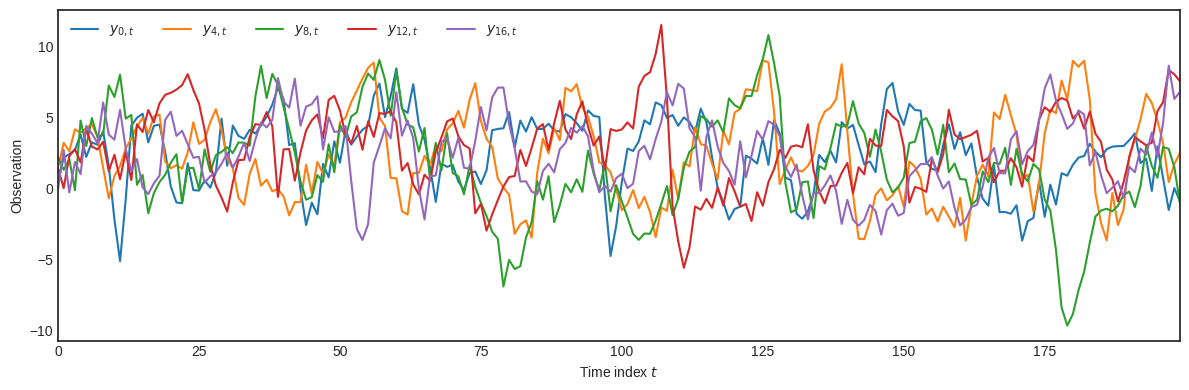

In [5]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 1, 1)
ax.plot(observation_time_indices, observation_sequence[:, ::4])
ax.set_xlabel('Time index $t$')
ax.set_ylabel('Observation')
ax.legend([f'$y_{{{i},t}}$' for i in range(0, model.dim_observation, 4)], ncol=5)
_ = ax.set_xlim(0, observation_time_indices.max())
fig.tight_layout()

## Infer state from observations

In [6]:
def plot_results(results, space_indices, observation_time_indices, state_sequence=None, 
                 plot_particles=False, plot_region=True, 
                 particle_skip=2, trace_alpha=0.5):
    fig, axes = plt.subplots(nrows=len(space_indices), ncols=1, sharex=True, 
                             figsize=(12, len(space_indices) * 3))
    for i, ax in zip(space_indices, axes):
        ax.plot(results['state_mean_sequence'][:, i], 'g-', lw=1, label='Est. mean')
        if plot_region:
            ax.fill_between(
                observation_time_indices,
                results['state_mean_sequence'][:, i] - 3 * results['state_std_sequence'][:, i],
                results['state_mean_sequence'][:, i] + 3 * results['state_std_sequence'][:, i],
                alpha=0.25, color='g', label='Est. mean ± 3 standard deviation'
            )
        if plot_particles:
            ax.plot(observation_time_indices, results['state_particles_sequence'][:, ::particle_skip, i], 
                    'r-', lw=0.25, alpha=trace_alpha)
            lines[0].set_label('Particles')
        if state_sequence is not None:
            ax.plot(observation_time_indices, state_sequence[:, i], 'k--', label='Truth')
        ax.set_ylabel(f'$x_{{{i},t}}$')
        ax.legend(loc='upper center', ncol=4)
    ax.set_xlabel('Time index $t$')
    fig.tight_layout()
    return fig, axes

### Ensemble Kalman filter (perturbed observations)

In [7]:
enkf = filters.EnsembleKalmanFilter()

In [8]:
results_enkf = enkf.filter(
    model, observation_sequence, observation_time_indices, 
    num_particle=100, rng=rng, return_particles=True)

Filtering: 100%|██████████|200/200 [00:00<00:00, 301.80time-steps/s]

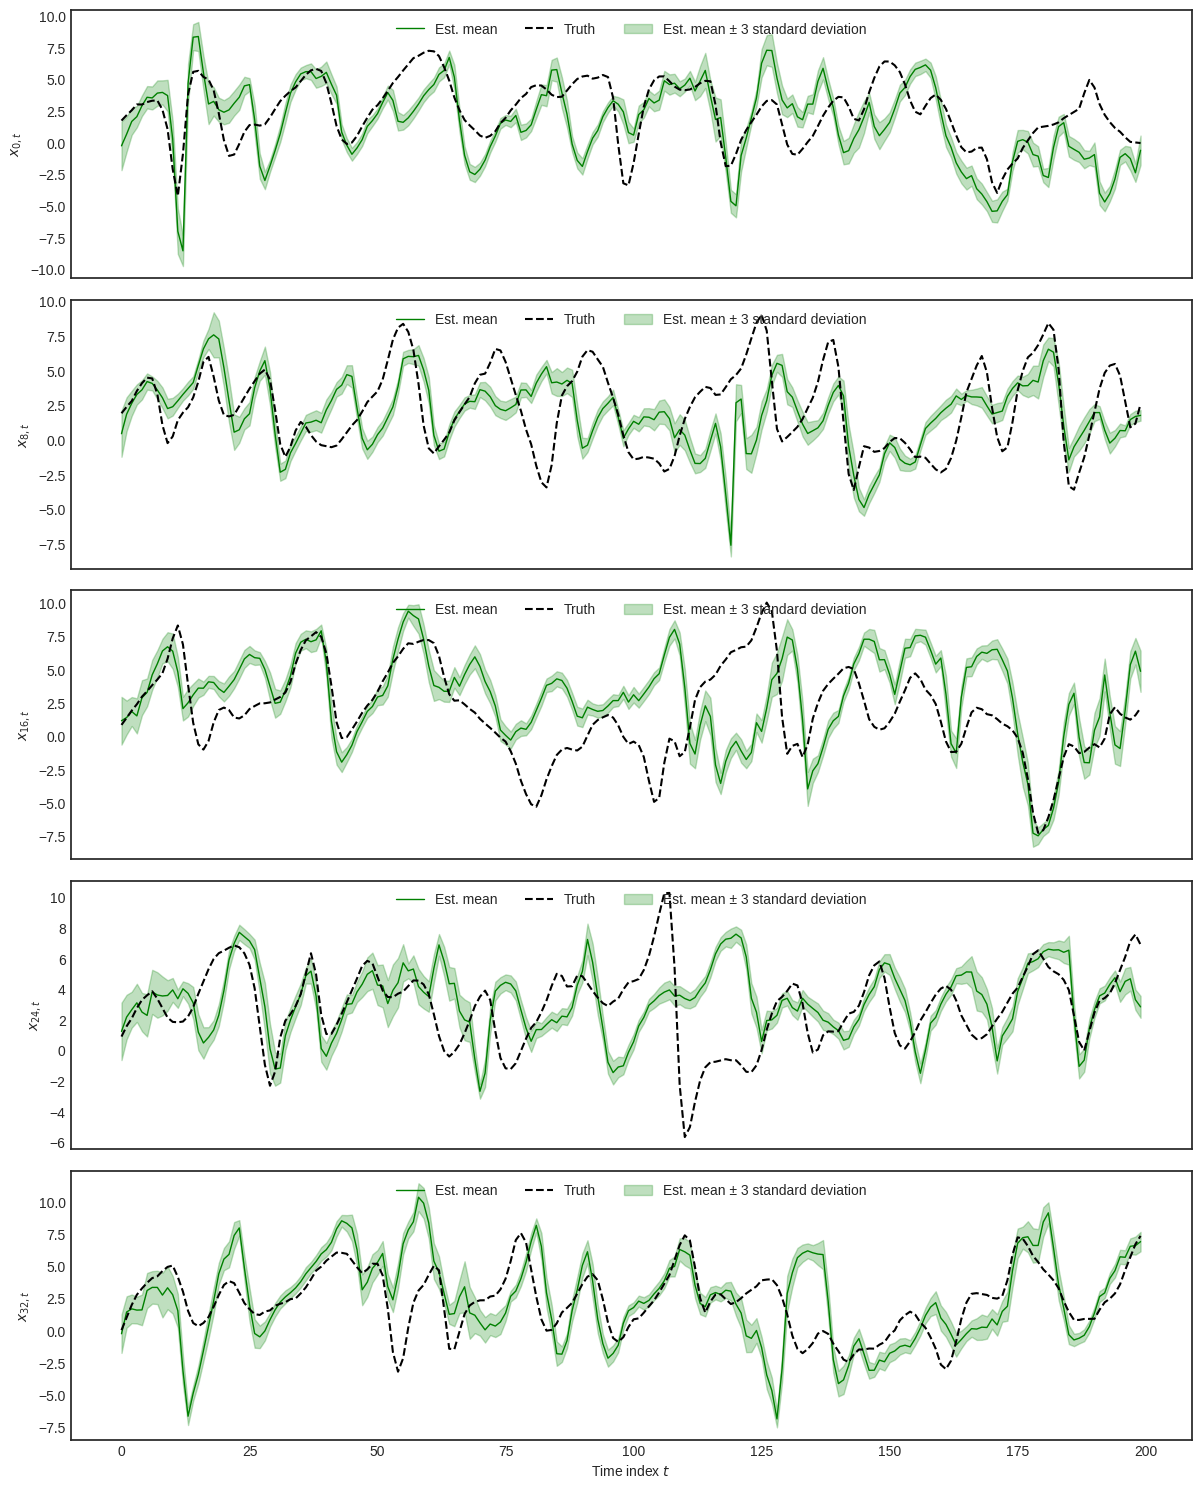

In [9]:
fig, axes = plot_results(
    results_enkf, range(0, model.dim_state, 8),  observation_time_indices, state_sequence)

### Ensemble trasform Kalman filter (deterministic square root)

In [10]:
etkf = filters.EnsembleTransformKalmanFilter()

In [11]:
results_etkf = etkf.filter(
    model, observation_sequence, observation_time_indices, 
    num_particle=100, rng=rng, return_particles=True)

Filtering: 100%|██████████|200/200 [00:00<00:00, 275.58time-steps/s]

In [12]:
fig, axes = plot_results(
    results_etkf, range(0, model.dim_state, 8),  observation_time_indices, state_sequence)

### Local ensemble transform Kalman filter

In [13]:
letkf = filters.LocalEnsembleTransformKalmanFilter(localisation_radius=0.6)

In [14]:
results_letkf = letkf.filter(
    model, observation_sequence, observation_time_indices, 
    num_particle=50, rng=rng, return_particles=True)

Filtering: 100%|██████████|200/200 [00:01<00:00, 114.46time-steps/s]

In [15]:
fig, axes = plot_results(
    results_letkf, range(0, model.dim_state, 8),  observation_time_indices, state_sequence)

### Bootstrap particle filter

In [16]:
bspf = filters.BootstrapParticleFilter()

In [17]:
results_bspf = bspf.filter(
    model, observation_sequence, observation_time_indices, 
    num_particle=100, rng=rng, return_particles=True)

Filtering: 100%|██████████|200/200 [00:01<00:00, 191.40time-steps/s]

In [18]:
fig, axes = plot_results(
    results_bspf, range(0, model.dim_state, 8),  observation_time_indices, state_sequence)

### Ensemble transform particle filter

In [19]:
etpf = filters.EnsembleTransformParticleFilter()

In [20]:
results_etpf = etpf.filter(
    model, observation_sequence, observation_time_indices, 
    num_particle=100, rng=rng, return_particles=True)

Filtering: 100%|██████████|200/200 [00:01<00:00, 193.46time-steps/s]

In [21]:
fig, axes = plot_results(
    results_etpf, range(0, model.dim_state, 8),  observation_time_indices, state_sequence)

## Localised ensemble transform particle filter

In [22]:
letpf = filters.LocalEnsembleTransformParticleFilter(localisation_radius=0.6)

In [23]:
results_letpf = letpf.filter(
    model, observation_sequence, observation_time_indices, 
    num_particle=50, rng=rng, return_particles=True)

Filtering: 100%|██████████|200/200 [00:05<00:00, 37.47time-steps/s]

In [24]:
fig, axes = plot_results(
    results_letpf, range(0, model.dim_state, 8),  observation_time_indices, state_sequence)

## Scalable localised ensemble transform particle filter

In [25]:
letpf = filters.ScalableLocalEnsembleTransportParticleFilter(localisation_radius=0.6)

In [26]:
results_sletpf = letpf.filter(
    model, observation_sequence, observation_time_indices, 
    num_particle=50, rng=rng, return_particles=True)

Filtering: 100%|██████████|200/200 [00:03<00:00, 53.62time-steps/s]

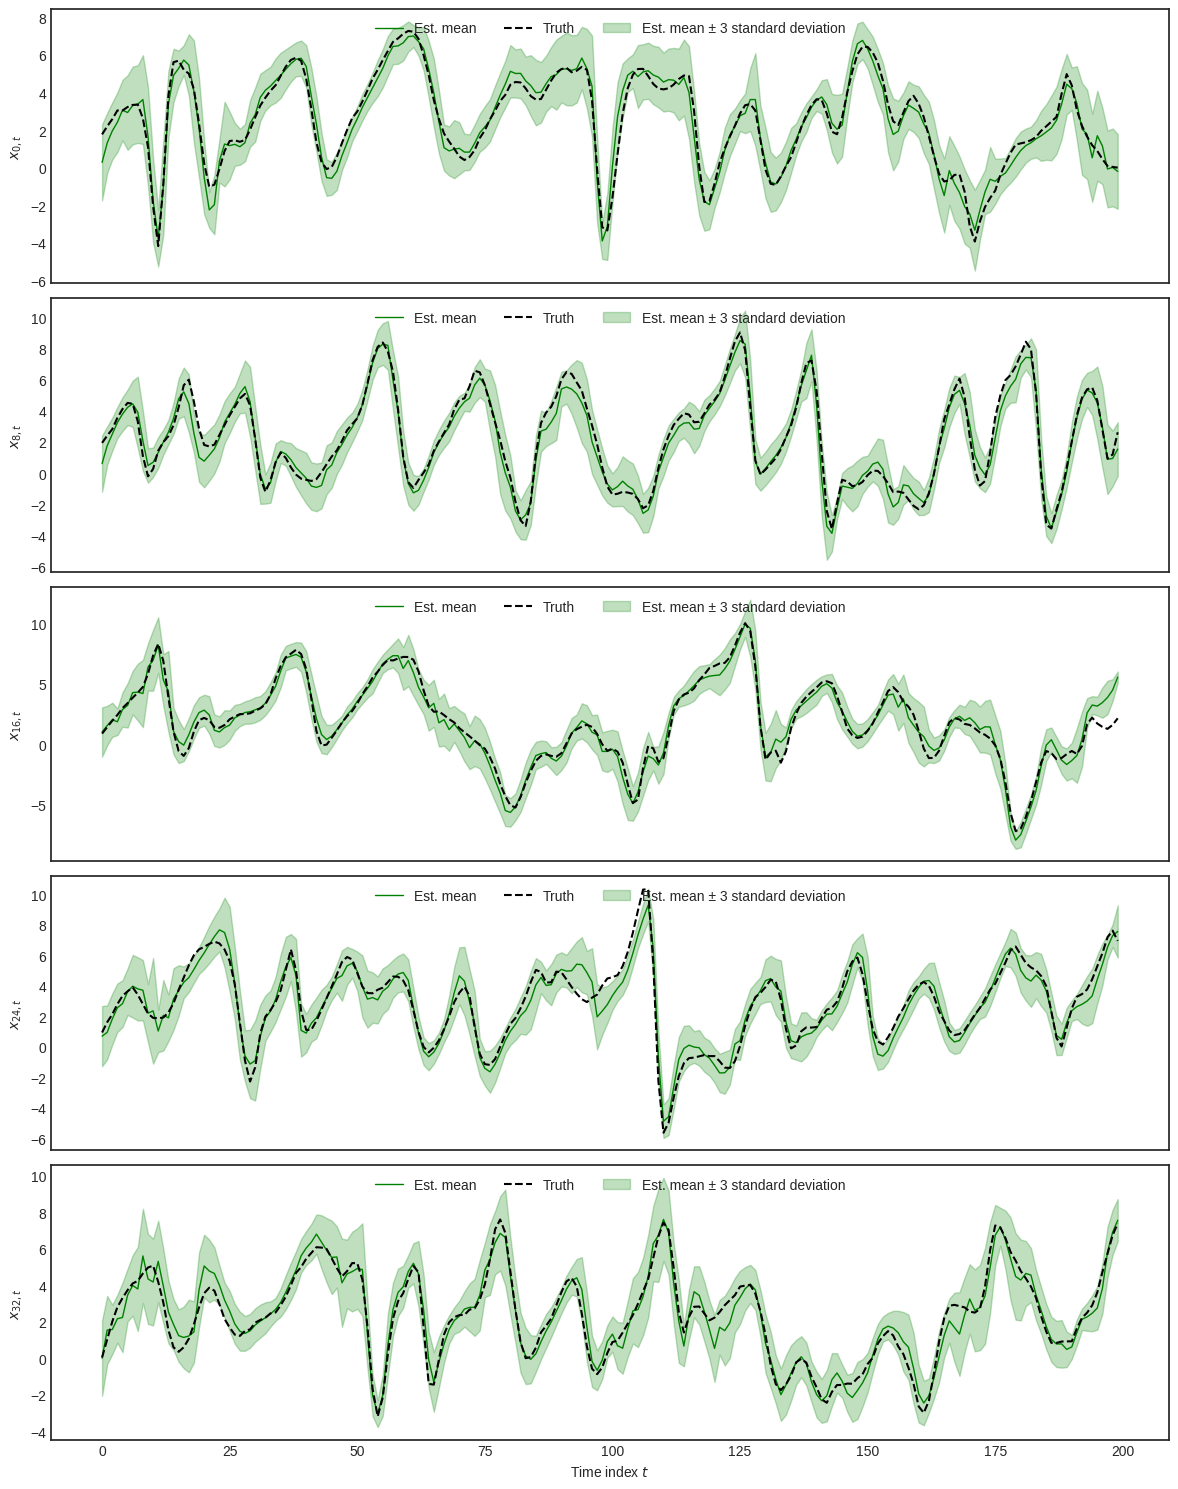

In [27]:
fig, axes = plot_results(
    results_sletpf, range(0, model.dim_state, 8),  observation_time_indices, state_sequence)